
# Dataset y consigna del TP


Descargar el dataset **Global Climate Change Data** https://data.world/data-society/global-climate-change-data

<ul>
<li>Graficar una serie a partir de un dataset relevante. Describir observaciones.</li>
<li> Descomponer una serie de tiempo usando el modelo aditivo de cuatro componentes. </li>
<li> Extraer la tendencia y ajustar un modelo determinístico. Explicar su relación con el
contexto. Obtener conclusiones acerca de la validez del modelo. </li>
<li> <b> Entrega clase 4: </b> Evaluar si la serie original es estacionaria. Aplicar transformaciones
(preprocesamiento), graficar autocorrelación, autocorrelación parcial y extraer
conclusiones.
<li> <b>Entrega clase 6:</b> A partir de las transformaciones propuestas ajustar distintos modelos
(S)ARIMA. Extraer orden, parámetros, coeficientes numéricos y análisis de la bondad
del modelo.
<li> Ajustar y predecir usando redes neuronales LSTM. Comparar con predicciones
usando SARIMA y extraer conclusiones. </li>
<li> Reailzar el análisis espectral de la serie original. Hallar las frecuencias principales y
comparar con las componentes cíclica y estacional usando la descomposición. </li>
<li> <b> Entrega clase 8: </b> Presentación incluyendo introducción, gráficos, modelos propuestos,
expresiones analíticas y conclusiones. </li>

</ul>

# Importar librerías


In [103]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error


# Cargar datos
Cargar el dataset

In [12]:
from cmath import isnan


PATH_DATASET = "dataset-GlobalTemperatures.csv"

df = pd.read_csv(PATH_DATASET, delimiter=',')
df = df[['dt', 'LandAverageTemperature']]   # Extraigo solo columnas de interes
df = df.rename(columns={'LandAverageTemperature': 'temp'})

# Look at the dataset
# df.info()
print('\n Null count: \n', df.isnull().sum() )

# Hay 12 valores null en la temperatura. Imputo el promedio entre día anterior y posterior
nulls_index = df[df['temp'].isnull()].index.tolist()

for i in nulls_index:
    new_val = (df.at[i-1,'temp'] + df.at[i+1,'temp'])*0.5
    if(isnan(new_val) == True):   # Go backwards and find a valid value
        offset = 1
        prev_val = df.at[i-offset,'temp']
        while(isnan(prev_val)):
            offset += 1
            prev_val = df.at[i-offset,'temp']
        new_val = prev_val

    df.loc[i, 'temp'] = new_val
print('\n Null count after imputation: \n', df.isnull().sum() )
    
# Proceso columna de fecha para convertirla en datetime
df['dt'] = pd.to_datetime(df['dt'])
print(df.dtypes)

# Por último, seteo la fecha como indice del dataframe. Esto permite acceso cómodo
df = df.set_index('dt')

data = df.to_numpy().flatten()



 Null count: 
 dt       0
temp    12
dtype: int64

 Null count after imputation: 
 dt      0
temp    0
dtype: int64
dt      datetime64[ns]
temp           float64
dtype: object


In [13]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3192 entries, 1750-01-01 to 2015-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    3192 non-null   float64
dtypes: float64(1)
memory usage: 49.9 KB
None
              temp
dt                
1750-01-01   3.034
1750-02-01   3.083
1750-03-01   5.626
1750-04-01   8.490
1750-05-01  11.573


# Gráficos

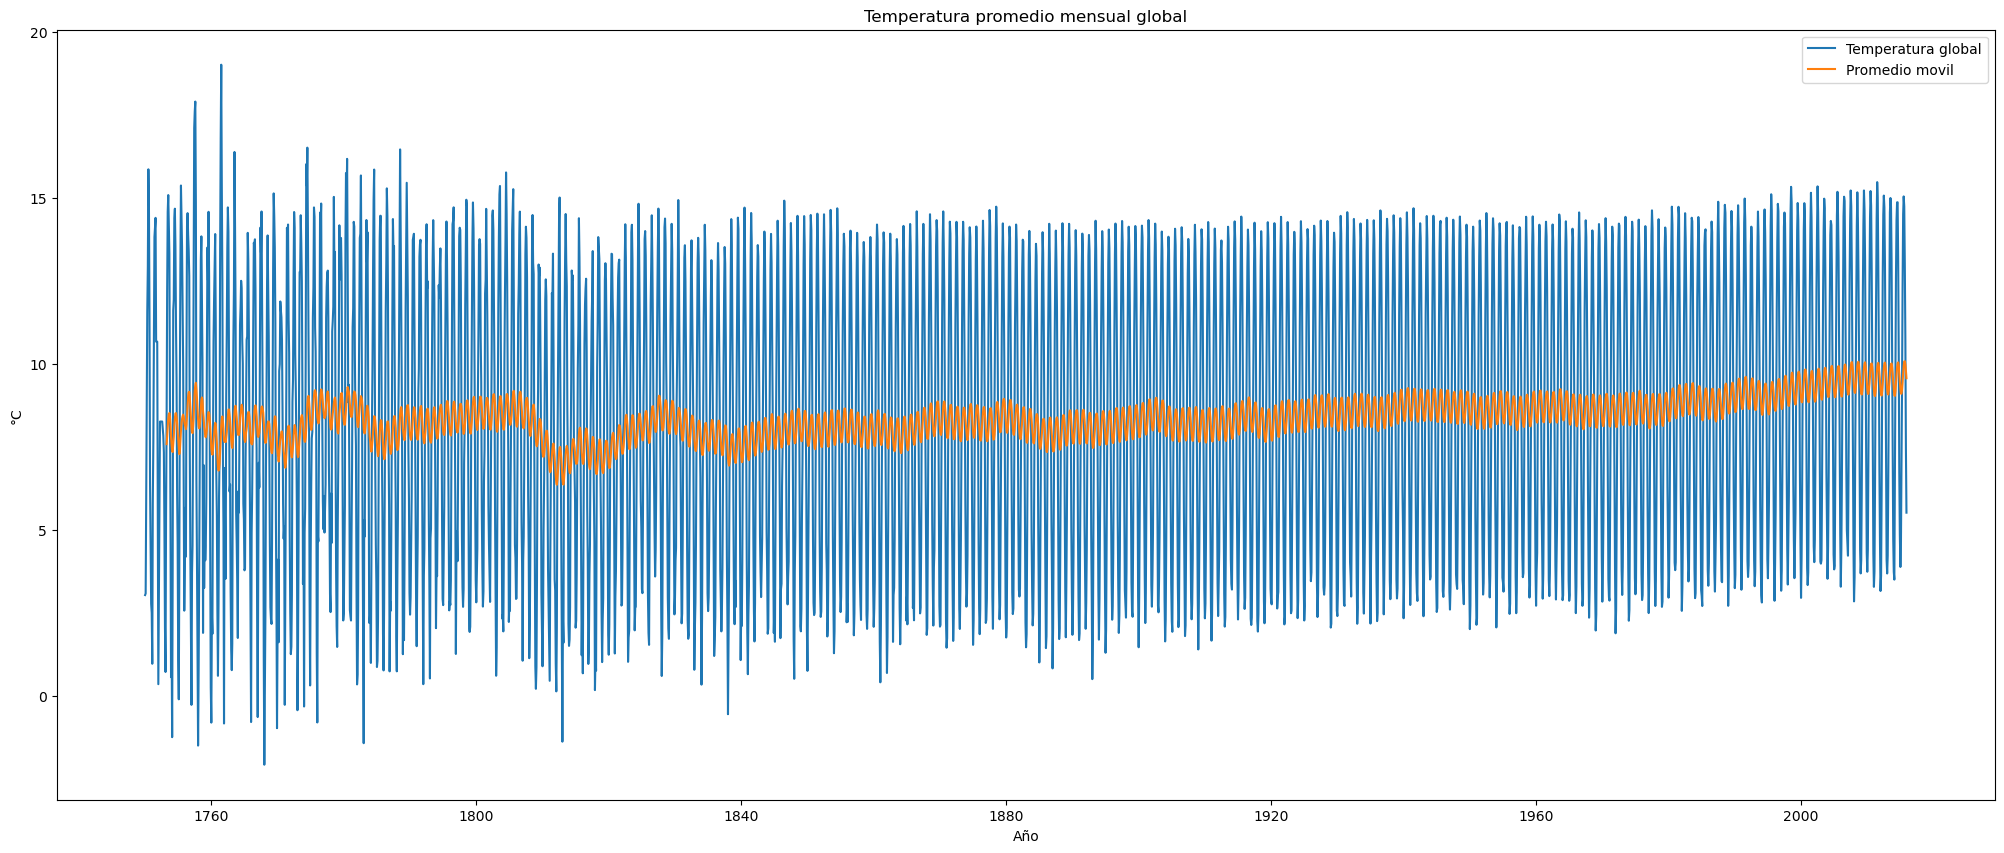

In [14]:
import pandas.core.window.rolling

s = pd.Series(data).rolling(40).mean()
plt.figure(figsize=(25,10))
plt.title('Temperatura promedio mensual global')
plt.xlabel('Año')
plt.ylabel('°C')
plt.plot(df.index.values, df['temp'].values, label='Temperatura global')
plt.plot(df.index.values, s, label='Promedio movil')
plt.legend(loc='upper right')
plt.show()

Se puede ver que la serie presenta muchas variaciones a lo largo de los 265 años que se registraron. Dado que son registros mensuales, el gráfico se vuelve muy ruidoso. Por ello se graficó encima la mediana móvil 40 muestras. Esta mediana muestra que la serie tiene una tendencia a aumentar, por lo que en una primera instancia se puede pensar que se trata de una serie no estacionaria.<br>

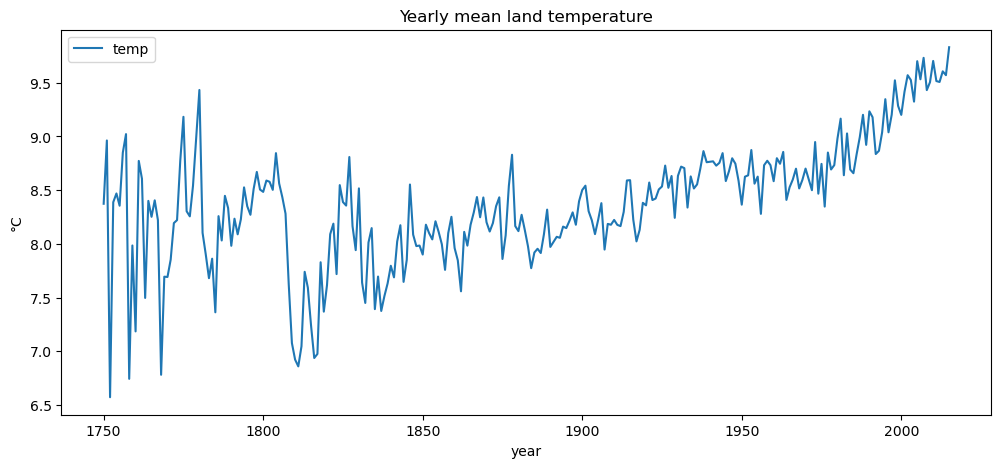

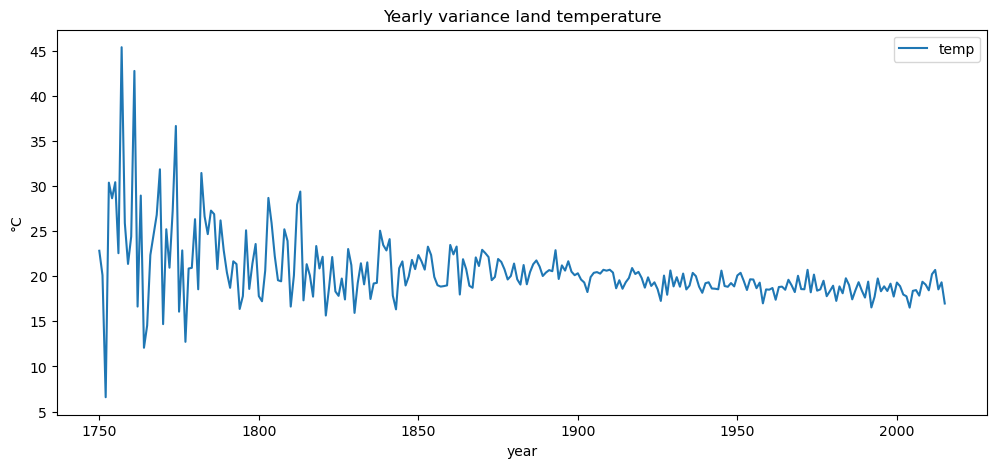

In [15]:
df.groupby(df.index.year).mean().plot(figsize=(12,5), title='Yearly mean land temperature', xlabel='year', ylabel='°C')
df.groupby(df.index.year).var().plot(figsize=(12,5), title='Yearly variance land temperature', xlabel='year', ylabel='°C')
plt.show()

El efecto de la tendencia se puede ver aún mejor si agrupamos los datos por año y calculamos el promedio anual de la temperatura. Con este gráfico se puede ver claramente que la temperatura global promedio anual tiene una tendencia a subir. Incluso se nota una gran aceleración en la escalada con un punto de inflexión significativo alrededor de los años 1960 y 1980.
Otro factor interesante se puede ver en la varianza de la temperatura anual. Se puede ver una disminución progresiva en la varianza, indicando que en cada año hay menor dispersión de los datos, manteniendo mayor uniformidad a lo largo de las distintas estaciones.
Cómo se propuso anteriormente, se puede ver claramente que la serie no es estacionaria, dado que la media y la varianza no se mantienen constantes a lo largo del tiempo.

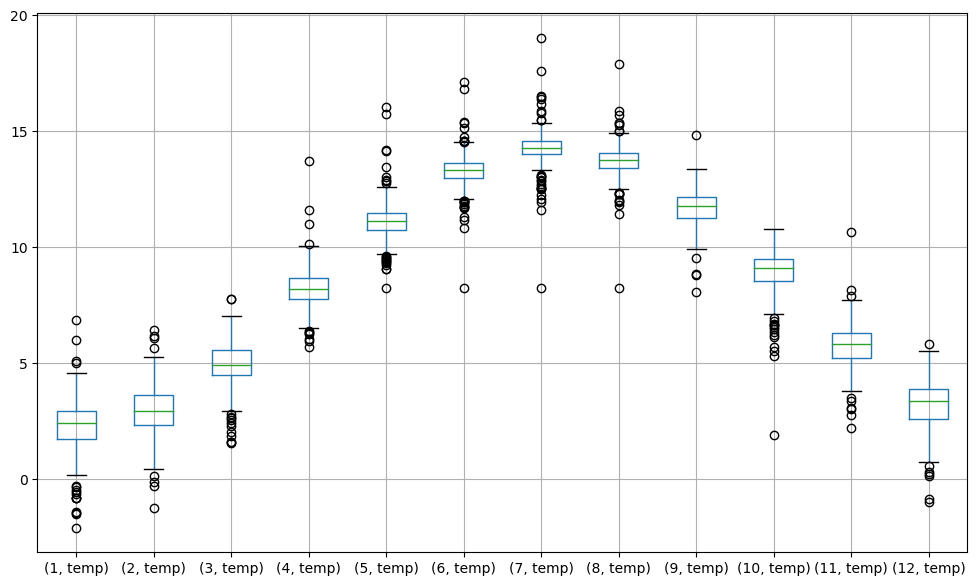

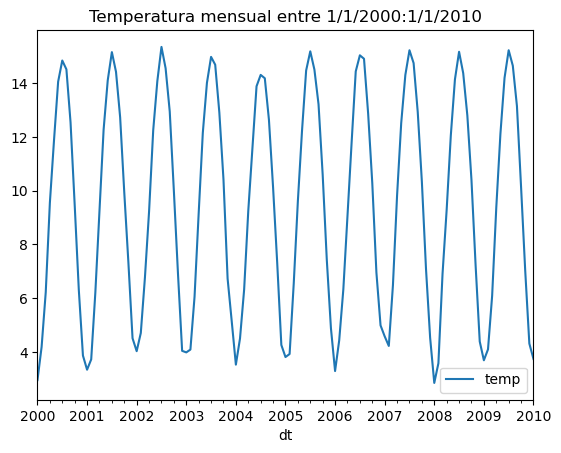

In [16]:
# Ahora veamos la estacionalidad
df.groupby(df.index.month).boxplot(subplots=False, sharex=True, figsize=(12,7))
df['1/1/2000':'1/1/2010'].plot(title='Temperatura mensual entre 1/1/2000:1/1/2010')
plt.show()

Acá se puede ver la estacionalidad de la serie, algo que no se podía apreciar en el gráfico anterior debido a la cantidad de muestras. En el primer gráfico se puede ver la distribución de cada mes a lo largo de todos los años. Acá se puede ver la estacionalidad de la serie a lo largo de un año. Estas variaciones se deben a la cercanía de la tierra con el sol a lo largo de un año.
En el segundo gráfico se presenta la serie original, con las T° de cada mes, pero en un período de 10 años. Esto permite apreciar las estaciones y se puede ver que el período de ciclos es de 1 año. La tendencia dentro de cada ciclo se denomina tendencia determinística, ya que se repite de forma predecible. Por esta razón, es importante descartar esta componente cíclica para hacer un análisis de la tendencia subyacente de la serie.

# Analisis Estacionaridad

Aunque a partir del gráfico se puede ver claramente que la serie es no estacionaria (tendencia creciente), proponemos 2 metodos analíticos:
<ul>
<li> Por autocorrelación </li>
<li> Por test de Dickey-Fuller </li>
</ul>

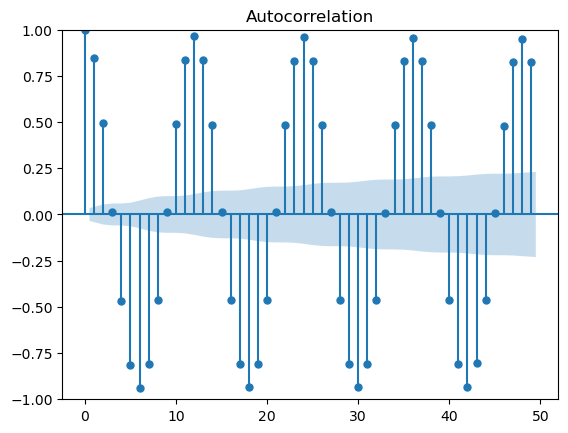

In [17]:
dpor = plot_acf(df['temp'], lags=np.arange(50))
plt.show()

Por autocorrelación, podemos ver que la serie tiene un comportamiento altamente cíclico. Esto es un indicio de que la serie no es estacionaria.

In [20]:
from statsmodels.tsa.stattools import adfuller
def my_adfuller(serie):
    print(f'Augmented Dickey-Fuller Test')
    result = adfuller(serie.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Mucha evidencia para rechazar Ho")
        print("Ho: Existe no estacionareidad")
        print("La serie es estacionaria")
    else:
        print("Poca evidencia para rechazar Ho")
        print("Ho: Existe no estacionareidad")
        print("No se puede rechazar hipotesis nula")

my_adfuller(df['temp'])

Augmented Dickey-Fuller Test
ADF test statistic        -3.886313
p-value                    0.002138
# lags used               28.000000
# observations          3163.000000
critical value (1%)       -3.432419
critical value (5%)       -2.862454
critical value (10%)      -2.567257
Mucha evidencia para rechazar Ho
Ho: Existe no estacionareidad
La serie es estacionaria


Dado que el valor del test (1.3) dió mayor a los valores críticos (1%, 5%, 10%), no podemos descartar la hipotesis nula de DFuller (Ho: Existe no estacionaridad en la serie).
Además, el p-valor es cercano a 1, por lo que con seguridad no podemos descartar la hipotesis nula.
Por lo tanto, la tendencia de la serie es no estacionaria.

# Descomposición del modelo

<Figure size 1000x700 with 0 Axes>

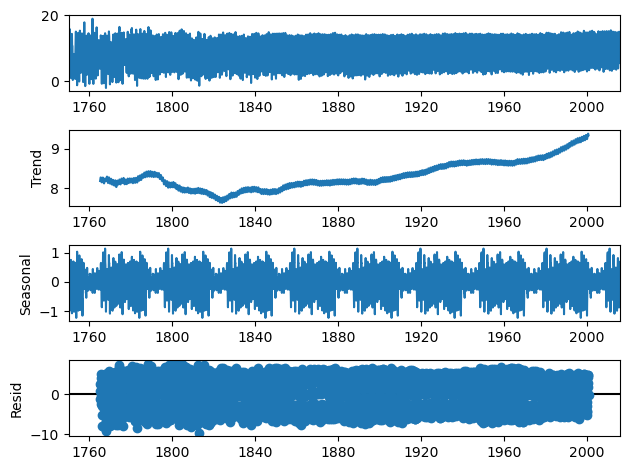

In [21]:
# Descomponemos el modelo usando un modelo aditivo con el período que determinamos antes
period=365
df_dec = sm.tsa.seasonal_decompose(df, model='additive', period=period)
fig=plt.figure(figsize=(10,7))
dec_plt = df_dec.plot()
plt.show()

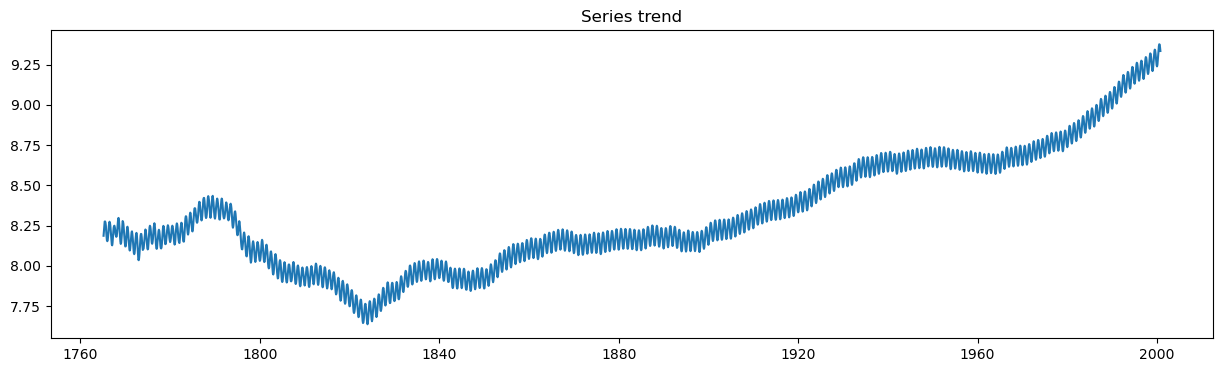

In [22]:
# Extraemos la curva de tendencia exclusivamente
fig=plt.figure(figsize=(15,4))
trend = df_dec._trend.dropna()  # Drop nans
plt.plot(trend)
plt.title('Series trend')
plt.show()

# Ajuste de modelo

## Tendencia
En una primera instancia, intentamos ajustar un modelo polinómico por cuadrados mínimos a la tendencia, con el objetivo de intentar predecir la serie.


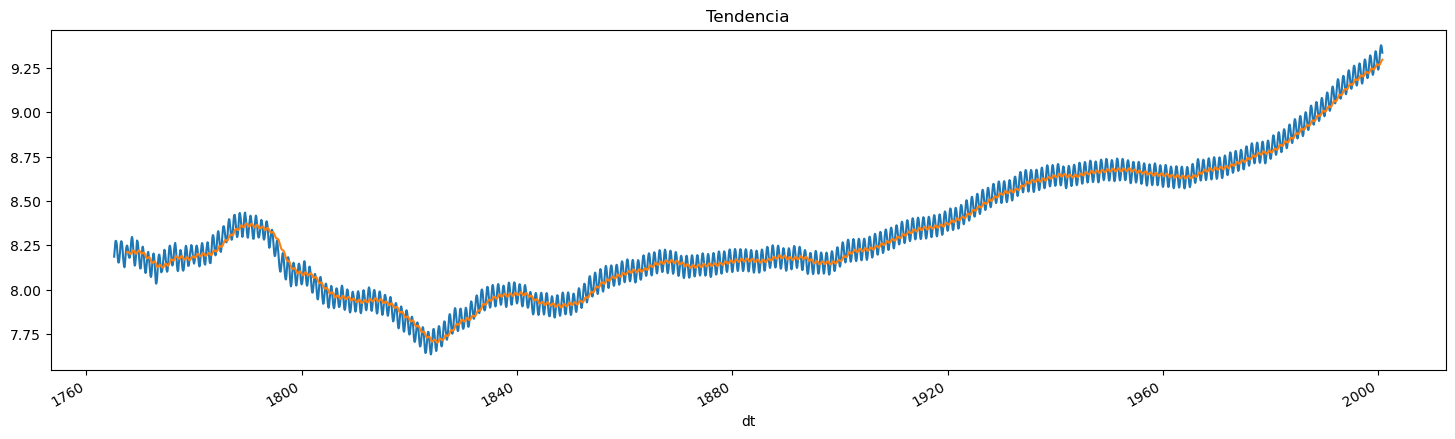

In [ ]:
# En primer lugar, filtramos la tendencia usando moving average para obtener un mejor ajuste 
trend_filt = pd.Series(trend).rolling(30).mean()
plt.figure(figsize=(18,5))
myAx = plt.plot(trend)
trend_filt.plot()
plt.title("Tendencia")
plt.show()

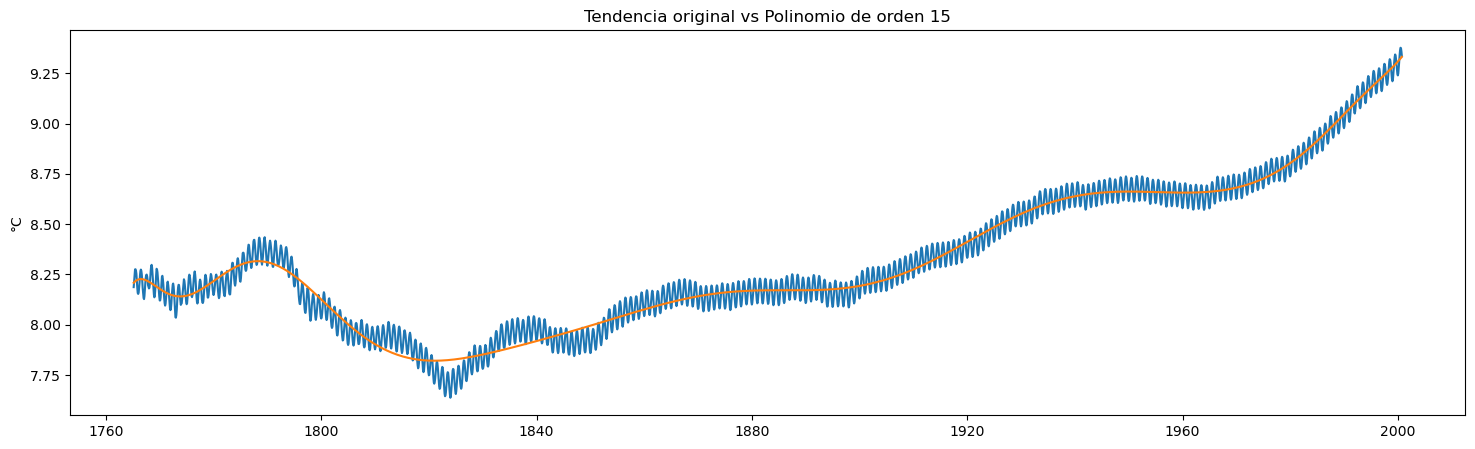

In [ ]:
poly_degree = 15    # Orden del polinomio a ajustar

x = np.arange(len(trend.index))
z = np.polyfit(x, trend.values, deg=poly_degree)  # Fitteo el polinomio:

# Ahora creo polinomio y computo nuevos valores para graficar
p = np.poly1d(z)    
trend_poly = trend.copy()
for i in x:
    trend_poly[i] = p(i)

# Grafico para comparar
plt.figure(figsize=(18,5))
plt.plot(trend)
plt.plot(trend_poly)
a= plt.title(('Tendencia original vs Polinomio de orden ' + str(poly_degree)))
a= plt.ylabel('°C')
plt.show()

Se puede ver que con un polinomio de grado 15, la tendencia se ajusta relativamente bien. Esto nos permitiría predecir, de una forma muy sencilla, cómo se esperaría que avance la serie temporal.

## Separacion train-test

En las imágenes de temperatura anual promedio y su varianza presentada anteriormente, se nota un comportamiento distinto entre el período 1750-1825 respecto de 1825-2015:
<ul>
<li>La media en el primer período es casi estable, pero la varianza cambia significativamente. </li>
<li>En segundo período la varianza es casi estable y la media tiende a aumentar.</li>
<li>La varianza tiende a disminuir a medida que aumenta la serie.</li>
</ul>
Consideramos que existe una diferencia fundamental y compleja entre el primer y segundo período que escapa el alcance del análisis. Particularmente, se considera de mayor interés predecir la tendencia alcista de la temperatura en el segundo período.<br>
Por esta razón, tomaremos el segundo período para el análisis de SARIMA. 
<br>
<br>
Luego, antes de comenzar el análisis, separamos en train y test para luego poder calcular alguna metrica de las predicciones que hagamos y tener confianza en el modelo


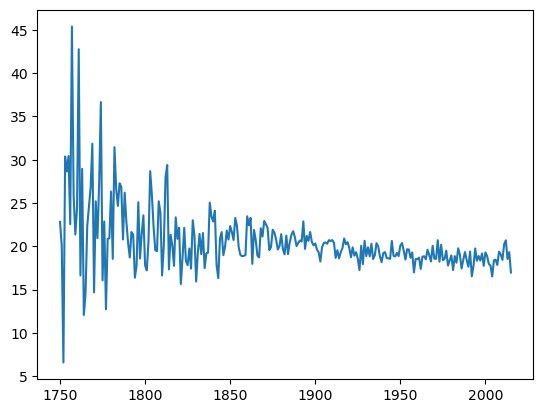

In [ ]:
# plt.plot(df['temp'])
plt.plot(df['temp'].groupby(df.index.year).var())

In [94]:
index_t0 = 75 * 12  # Start from the year 1825
data = df['temp'].values[index_t0:]
train_prc = 0.9 # Percentage of dataset to use for train
index=int(len(data)*train_prc)

y_train=data[:index]
x_train = df.iloc[index_t0:index_t0+index].index.values

y_test=data[index:]
x_test = df.iloc[index_t0+index:].index.values

print(f'Train: {len(y_train)} - Test: {len(y_test)}')

Train: 2062 - Test: 230


## SARIMA

Ahora intentaremos analizar la serie con un modelo más complejo. Para esto intentaremos usar SARIMA, dado que tenemos una componente estacional.

### Diferenciacion

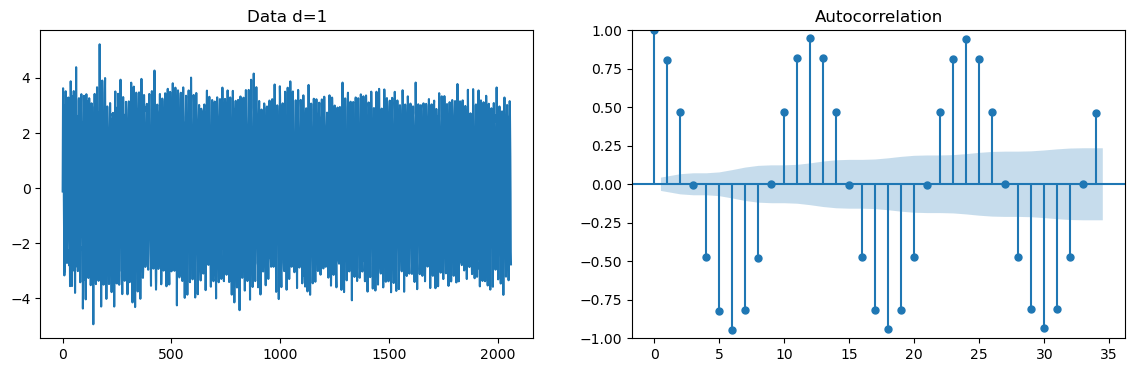

Augmented Dickey-Fuller Test
ADF test statistic     -1.306228e+01
p-value                 2.035713e-24
# lags used             2.600000e+01
# observations          2.034000e+03
critical value (1%)    -3.433569e+00
critical value (5%)    -2.862962e+00
critical value (10%)   -2.567527e+00
Mucha evidencia para rechazar Ho
Ho: Existe no estacionareidad
La serie es estacionaria


In [14]:
# Ya sabemos que la serie original no es estacionaria, por lo que diferenciamos una vez para eliminar la tendencia de la serie y luego analizamos estacionaridad
temp_d1 = pd.DataFrame((y_train - pd.Series(y_train).shift(1).values)[1:], columns=['temp'])
plt.figure(figsize=(14,4))
ax = plt.subplot(1,2,1)
plt.plot(temp_d1)
plt.title('Data d=1')
ax = plt.subplot(1,2,2)
a=plot_acf(temp_d1, ax=ax)
plt.show()
my_adfuller(temp_d1)

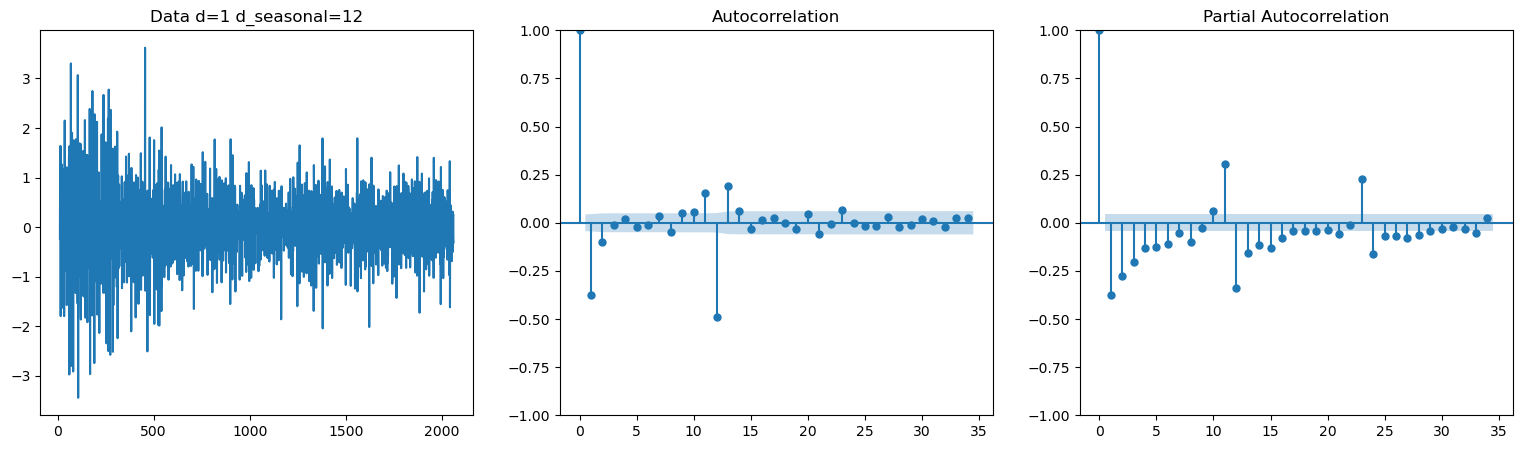

Augmented Dickey-Fuller Test
ADF test statistic     -1.516251e+01
p-value                 6.560360e-28
# lags used             2.600000e+01
# observations          2.022000e+03
critical value (1%)    -3.433588e+00
critical value (5%)    -2.862970e+00
critical value (10%)   -2.567532e+00
Mucha evidencia para rechazar Ho
Ho: Existe no estacionareidad
La serie es estacionaria


In [15]:
# Luego de diferenciar una vez, la serie se ve estacionari, pero aún se puede ver que la autocorrelación muestra una componente estacional.
# La autocorrelación sigue sin mostrar algo apropiado para hacer un modelado, por lo que diferencio una vez mas para sacar la componente estacional
temp_d1_s = pd.DataFrame((temp_d1['temp'] - temp_d1['temp'].shift(12))[12:], columns=['temp'])
plt.figure(figsize=(19,5))
ax = plt.subplot(1,3,1)
plt.plot(temp_d1_s)
plt.title('Data d=1 d_seasonal=12')
ax = plt.subplot(1,3,2)
a=plot_acf(temp_d1_s, ax=ax)
ax = plt.subplot(1,3,3)
a=plot_pacf(temp_d1_s, method='ywm', ax=ax)
plt.show()
my_adfuller(temp_d1_s)

### Generación de modelos y comparación

In [16]:
# Basado en los resultados de los gráficos, proponemos distintos modelos SARIMA que podrían representar apropiadamente la serie.
# Para los modelos de SARIMA(p,d,q)(P,D,Q)m proponemos:
import itertools

p = [2,3,4]
q = [0,1,2]
d = [1]
P = [0,1]
Q = [0,1]
D = [1]

params = list(itertools.product(p,d,q,P,D,Q,[12]))

models = []
aic = []
bic = []
for i in params:
    try:
        model = sm.tsa.statespace.SARIMAX(y_train, order=i[:3], seasonal_order=i[3:], enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=-1)
        this_aic = model_fit.aic
        this_bic = model_fit.bic
        print(f'SARIMA{i[:3]}x{i[3:]}12 - AIC={this_aic} - BIC={this_bic}')
        models.append(model)
        aic.append(this_aic)
        bic.append(this_bic)
    except:
        continue

SARIMA(2, 1, 0)x(0, 1, 0, 12)12 - AIC=3681.2933151995835 - BIC=3698.165706956567
SARIMA(2, 1, 0)x(0, 1, 1, 12)12 - AIC=2409.014817205445 - BIC=2431.4897867161267
SARIMA(2, 1, 0)x(1, 1, 0, 12)12 - AIC=3047.4362538363603 - BIC=3069.909258227867
SARIMA(2, 1, 0)x(1, 1, 1, 12)12 - AIC=2419.654767341985 - BIC=2447.7460228313685
SARIMA(2, 1, 1)x(0, 1, 0, 12)12 - AIC=3328.6657833094005 - BIC=3351.1623056520457
SARIMA(2, 1, 1)x(0, 1, 1, 12)12 - AIC=2080.55110083653 - BIC=2108.6423563259136
SARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC=2735.6586517625556 - BIC=2763.749907251939
SARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC=2082.555182692923 - BIC=2116.264689280183
SARIMA(2, 1, 2)x(0, 1, 0, 12)12 - AIC=3260.7706861764805 - BIC=3288.888895909038
SARIMA(2, 1, 2)x(0, 1, 1, 12)12 - AIC=2085.0252624038885 - BIC=2118.7318198635394
SARIMA(2, 1, 2)x(1, 1, 0, 12)12 - AIC=2711.5653779320187 - BIC=2745.2748845192787
SARIMA(2, 1, 2)x(1, 1, 1, 12)12 - AIC=2087.028192484955 - BIC=2126.3525095212144
SARIMA(3, 1, 0)x(0, 1, 0, 1

/Users/marcosb/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 1)x(0, 1, 0, 12)12 - AIC=nan - BIC=nan


/Users/marcosb/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 1)x(0, 1, 1, 12)12 - AIC=nan - BIC=nan


/Users/marcosb/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 1)x(1, 1, 0, 12)12 - AIC=nan - BIC=nan


/Users/marcosb/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 1)x(1, 1, 1, 12)12 - AIC=nan - BIC=nan
SARIMA(3, 1, 2)x(0, 1, 0, 12)12 - AIC=3238.6688696613337 - BIC=3272.410721340403
SARIMA(3, 1, 2)x(0, 1, 1, 12)12 - AIC=2085.911208674192 - BIC=2125.2355257104514
SARIMA(3, 1, 2)x(1, 1, 0, 12)12 - AIC=2684.186155334023 - BIC=2723.5104723702825
SARIMA(3, 1, 2)x(1, 1, 1, 12)12 - AIC=2087.955871000528 - BIC=2132.897947613396
SARIMA(4, 1, 0)x(0, 1, 0, 12)12 - AIC=3549.3766655074937 - BIC=3577.492430849878
SARIMA(4, 1, 0)x(0, 1, 1, 12)12 - AIC=2267.1418556726994 - BIC=2300.854309938722
SARIMA(4, 1, 0)x(1, 1, 0, 12)12 - AIC=2916.2638111114056 - BIC=2949.967417993176
SARIMA(4, 1, 0)x(1, 1, 1, 12)12 - AIC=2258.1643417993478 - BIC=2297.485216494746


/Users/marcosb/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(4, 1, 1)x(0, 1, 0, 12)12 - AIC=nan - BIC=nan


/Users/marcosb/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(4, 1, 1)x(0, 1, 1, 12)12 - AIC=nan - BIC=nan


/Users/marcosb/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(4, 1, 1)x(1, 1, 0, 12)12 - AIC=nan - BIC=nan


/Users/marcosb/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(4, 1, 1)x(1, 1, 1, 12)12 - AIC=nan - BIC=nan
SARIMA(4, 1, 2)x(0, 1, 0, 12)12 - AIC=3231.403911359792 - BIC=3270.76598283913
SARIMA(4, 1, 2)x(0, 1, 1, 12)12 - AIC=2087.808783209676 - BIC=2132.750859822544
SARIMA(4, 1, 2)x(1, 1, 0, 12)12 - AIC=2670.4298772350076 - BIC=2715.3680197440344


/Users/marcosb/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(4, 1, 2)x(1, 1, 1, 12)12 - AIC=2087.2382383935087 - BIC=2137.7936487161637


In [17]:
bm_index = np.nanargmin(aic)
best_model = models[bm_index].fit(disp=-1)
print(f'Best model is #{bm_index} --> SARIMA{params[bm_index][:3]}x{params[bm_index][3:]}12')
print(best_model.summary())

Best model is #5 --> SARIMA(2, 1, 1)x(0, 1, 1, 12)12
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 2062
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1035.276
Date:                            Fri, 14 Oct 2022   AIC                           2080.551
Time:                                    18:29:37   BIC                           2108.642
Sample:                                         0   HQIC                          2090.857
                                           - 2062                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3117      0.016     19.313      0.000       

### Análisis de bondad

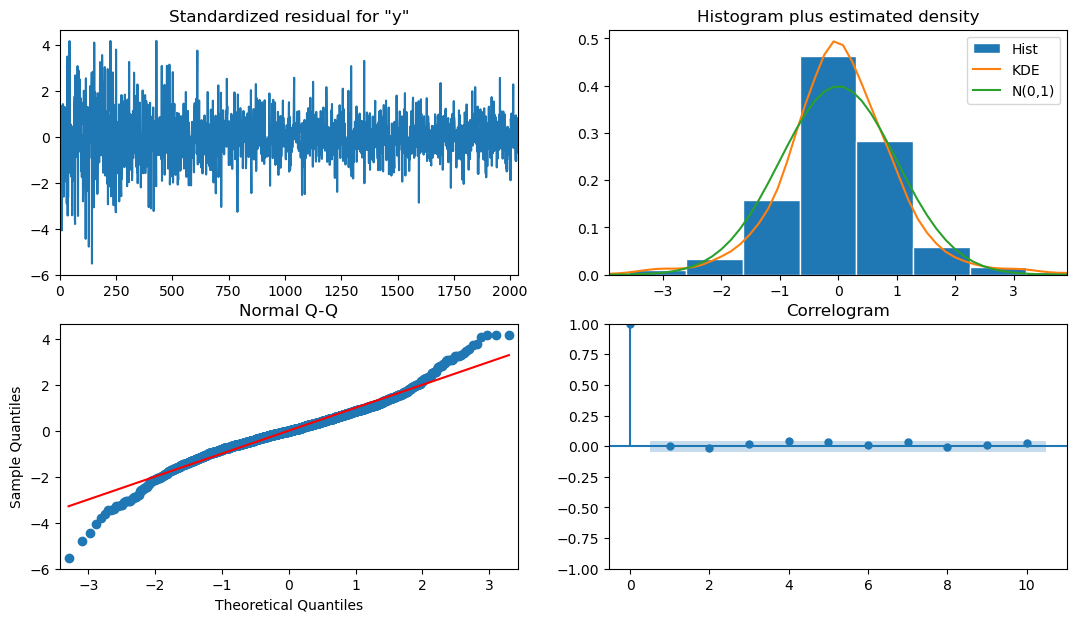

In [18]:
a=best_model.plot_diagnostics(figsize=(13,7))


A partir del análisis de residuos resultante, se puede decir que el modelo se ajusta correctamente y es un modelo válido para la serie de tiempo de interés.
Tanto el histograma como el QQplot muestran que los residuos tienen una distribución que se asemeja a la distribución normal, lo cuál es deseado.

# Predicción
Basandonos en el modelo SARIMA obtenido anteriormente, procedemos a intentar predecir la serie de tiempo, comparándola con el set de test.

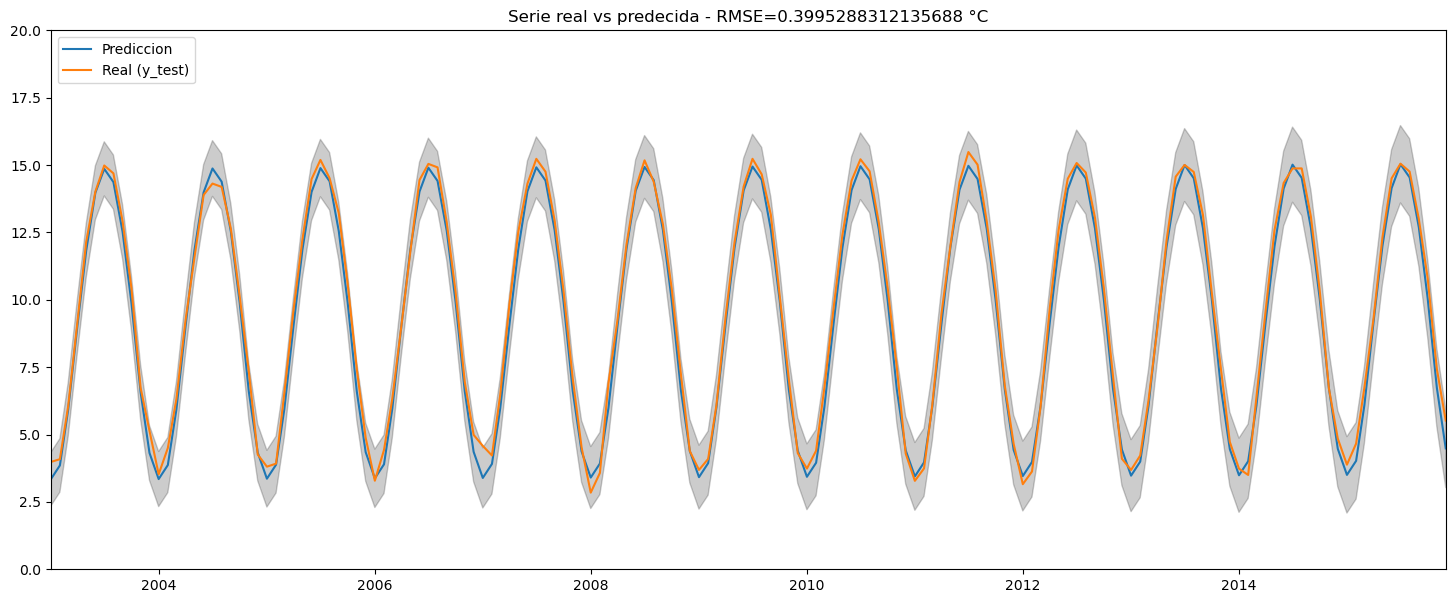

In [212]:
forecast = best_model.get_forecast(steps=len(y_test))
pred=forecast.predicted_mean
ci = forecast.conf_int()
mse = mean_squared_error(y_test, pred)


x_values = x_test
years_to_show = 13
plt.figure(figsize=(18,7))
plt.xlim(x_values[-(years_to_show*12)], x_values[-1])
plt.ylim(0,20)
plt.plot(x_values, pred, label='Prediccion')
plt.plot(x_values, y_test, label='Real (y_test)')
plt.fill_between(x=x_values, y1=ci[:, 0], y2=ci[:, 1], color='k', alpha=.2)
plt.title(f'Serie real vs predecida - RMSE={np.sqrt(mse)} °C')
plt.legend(loc='upper left')
plt.show()

Podemos ver que el modelo SARIMA obtenido predice correctamente la serie para el dataset de test. Esto corresponde a unos 13 años de mediciones de temperatura.

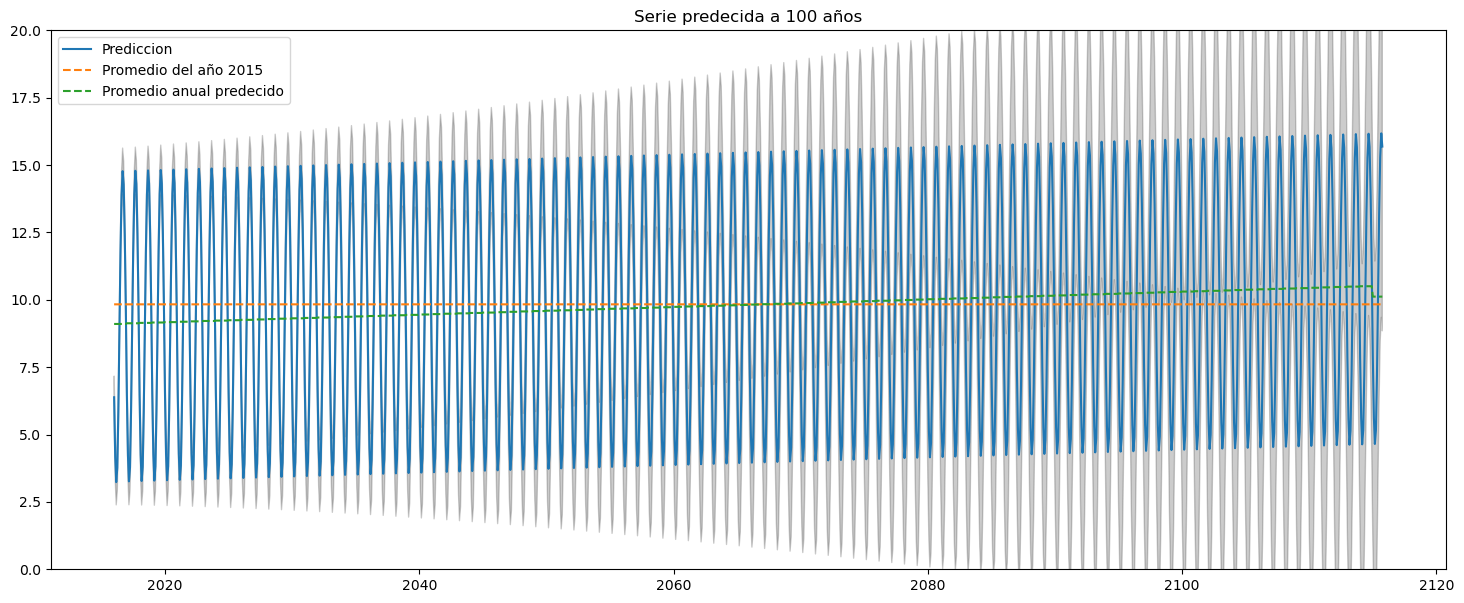

In [205]:
# Ahora, vamos cómo sería el futuro
from datetime import datetime, timedelta

future_years = 100
t_new = pd.date_range(x_test[-1] + np.timedelta64(31,'D'), x_test[-1] + np.timedelta64(365*future_years,'D') , freq='1M')-pd.offsets.MonthBegin(1)

forecast = best_model.get_forecast(steps=len(t_new))
pred=forecast.predicted_mean
ci = forecast.conf_int()

x_values = t_new
years_to_show = future_years
plt.figure(figsize=(18,7))
# plt.xlim(x_values[-(years_to_show*12)], x_values[-1])
plt.ylim(0,20)
plt.plot(x_values, pred, label='Prediccion')
plt.plot(x_values, [df.groupby(df.index.year).mean().iloc[-1].values]*len(x_values), '--', label='Promedio del año 2015')   # Plot mean of last measured year

# Generate yearly mean values of predicted series
temp_y_mean = [0]*len(x_values)   # Array of months predicted
temp_df = pd.DataFrame(pred, index=x_values)    # temporary dataframe
aux = temp_df.groupby(temp_df.index.year).mean().values
for i in range(len(temp_y_mean)):
    temp_y_mean[i] = aux[int(i/12)] 
plt.plot(x_values, temp_y_mean, '--', label='Promedio anual predecido') # Plot mean of predicted years

plt.fill_between(x=x_values, y1=ci[:, 0], y2=ci[:, 1], color='k', alpha=.2)
plt.title(f'Serie predecida a {future_years} años')
plt.legend(loc='upper left')
plt.show()


In [109]:
test = pd.DataFrame(pred, index=x_values)
print(test.groupby(test.index.year).mean())

              0
2016   9.102568
2017   9.128434
2018   9.142602
2019   9.156769
2020   9.170936
...         ...
2111  10.460135
2112  10.474302
2113  10.488469
2114  10.502636
2115  10.116774

[100 rows x 1 columns]


In [105]:
## Ahora veamos el promedio anual, 

temp    5.518
Name: 2015-12-01 00:00:00, dtype: float64


- Como agregar la tendencia deterministica y evitar la lineal del sarima?
    Leer la documentacion. No hace falta hacerlo igual.`
- Seleccion de parametros SARIMA
    Preprocesar un poco mas la serie. Hacer algo para sacarme la variacion en la varianza sino, no es estacionaria y no puedo sacar los parametros.
- Analisis de espectro de frecuencia
    Hacerlo sobre la diferenciada una vez.

# Analisis espectral

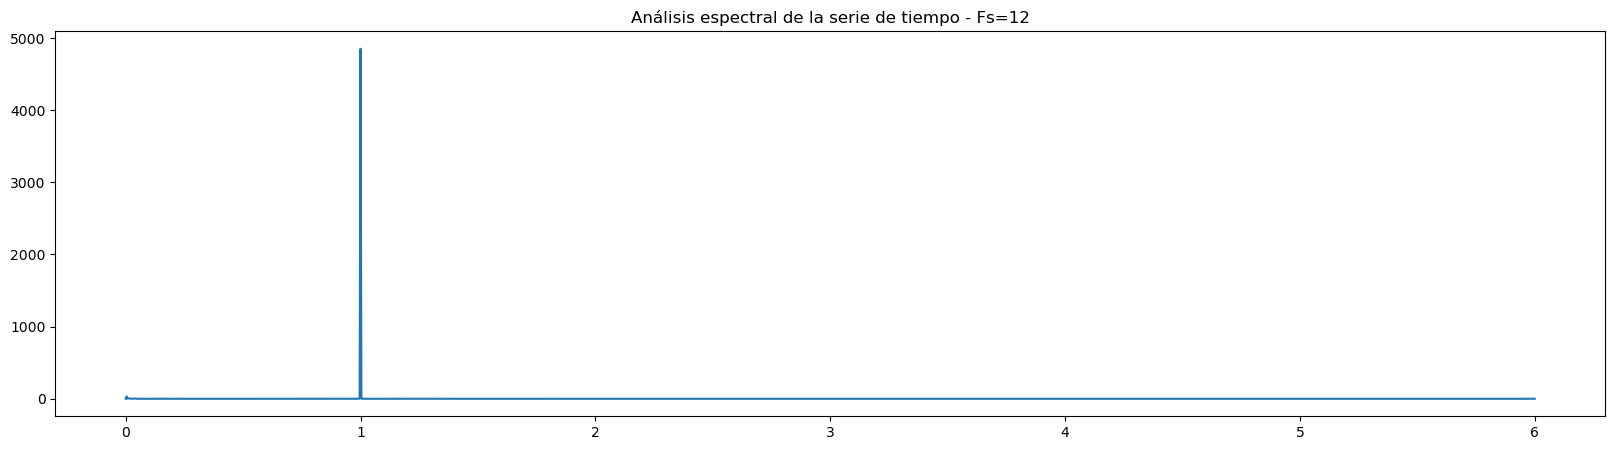

In [190]:
# Vamos a realizar un análisis espectral de la serie original para evaluar sus componentes periódicas
from scipy import signal
G, Pyy_den = signal.periodogram(df['temp'].values, 12)
plt.figure(figsize=(20,5))
plt.plot(G, Pyy_den)
plt.title('Análisis espectral de la serie de tiempo - Fs=12')
# plt.xlim(0,15)
plt.show()


Se puede ver en el análisis espectral una componente significativa alrededor de la frecuencia unitaria, que para la frecuencia de muestreo de 12 corresponde a los 12 meses del año. 

# Ajuste por redes neuronales LSTM

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim

In [119]:
def train_test(df, test_periods):
    train = df[:-test_periods].values
    test = df[-test_periods:].values
    return train, test
    
test_periods = 100
train_lstm, test_lstm = train_test(df, test_periods)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_lstm)
train_lstm_scaled = scaler.transform(train_lstm)

train_lstm_scaled = torch.FloatTensor(train_lstm_scaled)
print(f'Original dimensions : {train_lstm_scaled.shape}')
train_lstm_scaled = train_lstm_scaled.view(-1)
print(f'Correct dimensions : {train_lstm_scaled.shape}')

Original dimensions : torch.Size([3092, 1])
Correct dimensions : torch.Size([3092])


In [122]:
def get_x_y_pairs(train_scaled, train_periods, prediction_periods):
    """
    train_scaled - training sequence
    train_periods - How many data points to use as inputs
    prediction_periods - How many periods to ouput as predictions
    """
    x_train = [train_scaled[i:i+train_periods] for i in range(len(train_scaled)-train_periods-prediction_periods)]
    y_train = [train_scaled[i+train_periods:i+train_periods+prediction_periods] for i in range(len(train_scaled)-train_periods-prediction_periods)]
    
    #-- use the stack function to convert the list of 1D tensors
    # into a 2D tensor where each element of the list is now a row
    x_train = torch.stack(x_train)
    y_train = torch.stack(y_train)
    
    return x_train, y_train

train_periods = 200
prediction_periods = test_periods
x_train, y_train = get_x_y_pairs(train_lstm_scaled, train_periods, prediction_periods)
print(x_train.shape)
print(y_train.shape)

torch.Size([2792, 200])
torch.Size([2792, 100])


In [123]:
class LSTM(nn.Module):
    """
    input_size - will be 1 in this example since we have only 1 predictor (a sequence of previous values)
    hidden_size - Can be chosen to dictate how much hidden "long term memory" the network will have
    output_size - This will be equal to the prediciton_periods input to get_x_y_pairs
    """
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size)
        
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden=None):
        if hidden==None:
            self.hidden = (torch.zeros(1,1,self.hidden_size),
                           torch.zeros(1,1,self.hidden_size))
        else:
            self.hidden = hidden
            
        """
        inputs need to be in the right shape as defined in documentation
        - https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        
        lstm_out - will contain the hidden states from all times in the sequence
        self.hidden - will contain the current hidden state and cell state
        """
        lstm_out, self.hidden = self.lstm(x.view(len(x),1,-1), self.hidden)
        
        predictions = self.linear(lstm_out.view(len(x), -1))
        
        return predictions[-1], self.hidden

In [129]:
model = LSTM(input_size=1, hidden_size=10, output_size=test_periods)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [130]:
epochs = 5
model.train()
for epoch in range(epochs+1):
    for x,y in zip(x_train, y_train):
        y_hat, _ = model(x, None)
        optimizer.zero_grad()
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        
    if epoch%1==0:
        print(f'epoch: {epoch:4} loss:{loss.item():10.8f}')

epoch:    0 loss:0.00064011
epoch:    1 loss:0.00050722
epoch:    2 loss:0.00045183
epoch:    3 loss:0.00042122
epoch:    4 loss:0.00040095
epoch:    5 loss:0.00038358


In [131]:
model.eval()
with torch.no_grad():
    predictions, _ = model(train_lstm_scaled[-train_periods:], None)
#-- Apply inverse transform to undo scaling
predictions = scaler.inverse_transform(np.array(predictions.reshape(-1,1)))

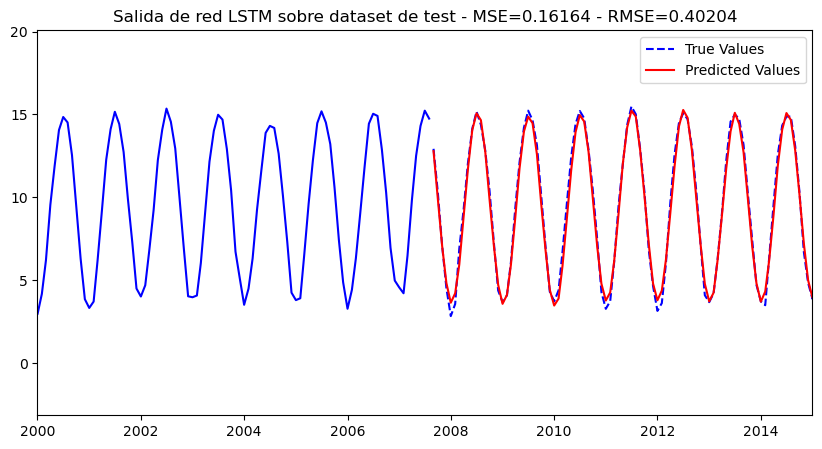

In [132]:
import datetime as dt
x = df.index
mse = mean_squared_error(df.temp[-len(predictions):], predictions)
rmse = np.sqrt(mse)

fig = plt.figure(figsize=(10,5))
plt.plot(x[:-len(predictions)], df.temp[:-len(predictions)], "b-")
plt.plot(x[-len(predictions):], df.temp[-len(predictions):], "b--", label='True Values')
plt.plot(x[-len(predictions):], predictions, "r-", label='Predicted Values')
plt.xlim('1/1/2000','1/1/2015')
plt.title(f'Salida de red LSTM sobre dataset de test - MSE={mse:.5f} - RMSE={rmse:.5f}')
plt.legend()